In [1]:
import torch
import os
import applyllm as apl

print(apl.__version__)

0.0.6


In [2]:
if not torch.backends.mps.is_available():
    print("MPS is not available")
else:
    print("MPS is available")
    mps_device = torch.device("mps")
    print(mps_device)

MPS is available
mps


In [3]:
from applyllm.accelerators import (
    DirectorySetting,
    TokenHelper as th,
)
from applyllm.utils import time_func
    
dir_mode_map = {
    "kf_notebook": DirectorySetting(),
    "mac_local": DirectorySetting(home_dir="/Users/yingding", transformers_cache_home="MODELS", huggingface_token_file="MODELS/.huggingface_token"),
}

model_map = {
    "diffusion-v1.5":     "runwayml/stable-diffusion-v1-5",
}

default_model_type = "diffusion-v1.5"
default_dir_mode = "mac_local"

dir_setting = dir_mode_map[default_dir_mode]

os.environ["WORLD_SIZE"] = "1" 
os.environ['XDG_CACHE_HOME'] = dir_setting.get_cache_home()

print(os.environ['XDG_CACHE_HOME'])

/Users/yingding/MODELS


In [4]:
import diffusers

print(diffusers.__version__)
print(torch.__version__)

0.27.2
2.2.2


In [5]:
model_type = "diffusion-v1.5"

model_name = model_map.get(model_type, default_model_type)
print(model_name)

runwayml/stable-diffusion-v1-5


In [13]:
from applyllm.pipelines import (
    ModelCatalog,
    KwargsBuilder
)
token_kwargs = th.gen_token_kwargs(model_type=model_type, dir_setting=dir_setting)
print(f"token_kwargs: {token_kwargs}")

# data_type = torch.bfloat16
data_type = torch.float16
device_map = "mps"
# auto caste not working for mps 4.38.2
# https://github.com/huggingface/transformers/issues/29431 

model_kwargs = {
    "torch_dtype": data_type, #bfloat16 is not supported on MPS backend, float16 only on GPU accelerator
    "pretrained_model_name_or_path": model_name,
}
print(f"model_kwargs: {model_kwargs}")

huggingface token is NOT needed
token_kwargs: {}
model_kwargs: {'torch_dtype': torch.float16, 'pretrained_model_name_or_path': 'runwayml/stable-diffusion-v1-5'}


## Use StableDiffusion Pipeline on MPS

Note: 
* Can not load the pipeline with `device_map='auto'``
* Need to manually move the cpu pipeline to GPU device `pipe = pipe.to("mps")`

In [14]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(**model_kwargs)
pipe = pipe.to(device_map)

prompt = "a photo of an astronaut riding a horse on mars"

@time_func
def img_gen(prompt: str):
    return pipe(prompt).images[0]

image = img_gen(prompt)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

executed: img_gen() python function
walltime: 32.77944898605347 in secs.


In [19]:
# create a directory "imgs" if it is not exist in the current working directory
img_dir = "imgs"
os.makedirs(img_dir, exist_ok=True)

In [28]:
img_file_name = "astronaut_on_mars.png"

def save_image(image, img_file_name):
    img_file_path = os.path.join(img_dir, img_file_name)
    # save the image to the file if not exist
    if not os.path.exists(img_file_path):
        image.save(img_file_path)
    return img_file_path

img_file_path = save_image(image, img_file_name)

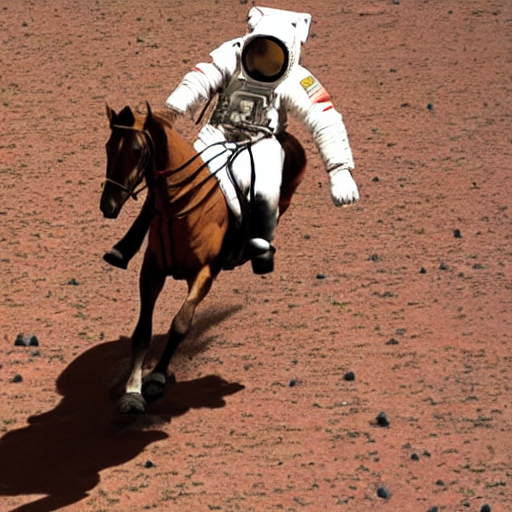

In [26]:
# reload and display the image file from the variable img_file_path in the Jupyter notebook cell inline
from PIL import Image
img = Image.open(img_file_path)
# show inline
display(img)
# show in extra window
# img.show()


In [29]:
prompt = "a dog with a red hat riding a skateboard on the street"

image = img_gen(prompt)

img_file_name = "dog_with_red_hat_on_skateboard.png"
img_file_path = save_image(image, img_file_name)

  0%|          | 0/50 [00:00<?, ?it/s]

executed: img_gen() python function
walltime: 18.93987202644348 in secs.


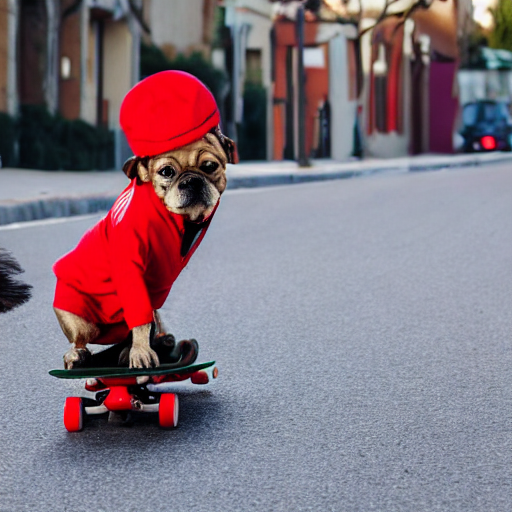

In [30]:
img = Image.open(img_file_path)
# show inline
display(img)